# Experiments with attention

In [ ]:
from bertviz import head_view, model_view
import transformers
import torch

In [ ]:
respd = pd.read_csv("res_100.csv")

In [ ]:
segm00 = """She convinced the guard to let her through the gates and she ran up the familiar stairs until she got to the potted bush next to the front door, 
she reached down and pulled out the spare key Joey kept there for her. She used them to unlock the door and then tossed her bag down, leaving the door open, and ran upstairs into his room. 
She then fell down on his bed, held onto a pillow and cried so hard that she didn"t even hear anyone enter the house. "MARY!" Joey yelled, standing dumb-struck in the doorway.[SEP]"Joh..n." 
her voice turned breathy, heat suffusing through her pores. A loud crash sounded behind them, echoing through the hall. They jerked apart and saw Marcos had accidentally dropped a cement block and created a hole in the floor while Lorna stood glaring at him. 
Then she bit out,"Nice going laser. As usual I"ll have to fix your mess." Then proceeded to maneuver a few metals plates through the hole in an attempt to mend it."""

In [ ]:
model1 = transformers.AutoModelForSequenceClassification.from_pretrained(r"..\BertAA_content\Model\Checkpoints\results_45000\checkpoint-225000", output_attentions=True).eval()
tokenizer1 = transformers.AutoTokenizer.from_pretrained(r"..\BertAA_content\Model\Checkpoints\results_45000\checkpoint-225000")

model2 = transformers.AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 2, output_attentions=True)
tokenizer2 = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
def get_head_view(segm, model, tokenizer, attention_layer):
    model = model.eval()
    text1, text2 = segm.split("$&*&*&$")
    inputs = tokenizer(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

    #sentence_a = "The cat sat on the mat"
    #sentence_b = "The cat lay on the rug"
    #inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')

    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    with torch.no_grad():
        global attention   
        attention = model(**inputs)[-1]
    sentence_b_start = token_type_ids[0].tolist().index(1)
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    h = head_view([attention[attention_layer]], tokens, sentence_b_start, html_action='return')
    return h

def get_head_view_avg(segm, model, tokenizer):
    model = model.eval()
    text1, text2 = segm.split("$&*&*&$")
    inputs = tokenizer(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

    #sentence_a = "The cat sat on the mat"
    #sentence_b = "The cat lay on the rug"
    #inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')

    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    with torch.no_grad():
        attention = model(**inputs)[-1]
    sentence_b_start = token_type_ids[0].tolist().index(1)
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)

    attention_mean = torch.Tensor()
    for l in attention:
        attention_mean = torch.cat((attention_mean, l), 0)
    attention_mean = torch.mean(attention_mean, 0, keepdim=True)

    h = head_view([attention_mean], tokens, sentence_b_start, html_action='return')
    return h

In [ ]:
#text1, text2 = respd[0][0].split("$&*&*&$")
text1, text2 = respd['text'][0].split("$&*&*&$")
inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

with torch.no_grad():
    global attention   
    attention = model1(**inputs)[-1]

In [ ]:
#inputs['input_ids'][0][128] #SEP
tokenizer1.decode(inputs['input_ids'][0][165])

'kindly'

In [ ]:
head4 = attention_mean[0][3][0]

In [ ]:
head1 = attention[4][0][0][0]

In [ ]:
sorted, indices = torch.sort(head1, descending=True)
print(indices[:10], sorted[:10])
#for i in indices[:5]:
#    print(tokenizer1.decode(inputs['input_ids'][0][i]))

tensor([128, 238,  65, 126,  27,  60,   0,  39,  82,  29]) tensor([0.2017, 0.1979, 0.0267, 0.0158, 0.0155, 0.0148, 0.0134, 0.0109, 0.0101,
        0.0092])


In [ ]:
import numpy as np

attention_mean = torch.Tensor()
for l in attention:
    attention_mean = torch.cat((attention_mean, l), 0)
attention_mean = torch.mean(attention_mean, 0, keepdim=True)



In [ ]:
h00f= get_head_view(segm00, model1, tokenizer1, 11)

In [ ]:
with open("h00cu.html", "w") as file:
    file.write(h.data)

In [ ]:
attention[11].shape

torch.Size([1, 12, 255, 255])

In [ ]:
from collections import Counter

def attention_per_layer(attention, layer, threshold = 0.01, mode='set'):
    """ For a given attention matrix, get the list of tokens with strongest attention from CLS
    in a given layer in all attention heads
    Parameters
    threshhold : float
        The minimal value that attention from CLS to a certain token should posess to be included into the list
        Value around 0.02 only selects most sturdy links and in practice is mst common towards [SEP] token
        Value around 0.01 selects most tokens with noticeably visualizable attention
        Value around 0.15 filters the list, favouring more important tokens, yet creates a broad and meaningful list
    """
    attended_by_cls = []

    for headnum, head in enumerate(attention[layer][0]):
        #print(headnum)
        cls = head[0]
        values, positions = torch.sort(cls, descending=True)
        #for index, word in enumerate(positions[:10]):
        for index, word in enumerate(positions):
            if values[index] >= threshold:
                attended_by_cls.append(tokenizer1.decode(inputs['input_ids'][0][word]))
    if mode == 'set':
        return set(attended_by_cls) #to proceed with counting jointly for all instances
    if mode == 'counter':
        count_attention = Counter(attended_by_cls) #count separately for each instance
        count_attention = count_attention.most_common()
        return count_attention

def attention_general(attention, threshold = 0.01, mode='set'):
    """ Get the list of tokens with strongest attention from CLS in all attention heads, for all layers, represented as
    a list of per-layer lists
    """
    attended_general = []
    for layernum, layer in enumerate(attention):
        #print(layernum)
        attended_at_layer = attention_per_layer(attention, layernum, threshold, mode)
        #print(attended_at_layer)
        attended_general.append(attended_at_layer)
    return attended_general

In [ ]:
def attention_at_head(attention, layer, head, threshold = 0.01):
    attended_by_cls = []
    cls = attention[layer][0][head][0]
    values, positions = torch.sort(cls, descending=True)
    #print(positions)
    for index, word in enumerate(positions):
        #print(str(values[index]) + ": " + tokenizer1.decode(inputs['input_ids'][0][word]))
        if values[index] >= threshold:
            attended_by_cls.append([tokenizer1.decode(inputs['input_ids'][0][word]), values[index], word])
    return(attended_by_cls)


In [ ]:
def reconstruct_token(inputs, position, trackname = True):
    curpos = position
    startpos = position
    endpos = position

    if "##" in tokenizer1.decode(inputs['input_ids'][0][curpos]):
        while "##" in tokenizer1.decode(inputs['input_ids'][0][curpos]):
            curpos -= 1
        startpos = curpos
        curpos = position
        while "##" in tokenizer1.decode(inputs['input_ids'][0][curpos]):
            curpos += 1
        endpos = curpos
        
    elif "##" in tokenizer1.decode(inputs['input_ids'][0][curpos + 1]):
        curpos += 1
        while "##" in tokenizer1.decode(inputs['input_ids'][0][curpos]):
            curpos += 1
        endpos = curpos

    else:
        endpos += 1

    if trackname:
        word = tokenizer1.decode(inputs['input_ids'][0][startpos:endpos])
        if checkname(word):
            return(tokenizer1.decode(inputs['input_ids'][0][startpos:endpos]))
        else:
            return(tokenizer1.decode(inputs['input_ids'][0][position]))
    else:
        return(tokenizer1.decode(inputs['input_ids'][0][startpos:endpos]))

In [ ]:
def checkname(word):
    return True if word[0].isupper() else False
   

In [ ]:
a = reconstruct_token(inputs, 48, trackname=False)
print(a)
print(checkname(a))


nibble
False


In [ ]:
for index, i in enumerate(range(len(inputs['input_ids'][0]))):
    print(index, tokenizer1.decode(inputs['input_ids'][0][i]))

0 [CLS]
1 He
2 sells
3 the
4 stuff
5 to
6 desperate
7 kids
8 who
9 need
10 the
11 sugar
12 rush
13 .
14 We
15 want
16 you
17 to
18 take
19 some
20 of
21 the
22 P
23 ##ez
24 they
25 carry
26 "
27 ,
28 said
29 Lisa
30 .
31 P
32 ##ez
33 ,
34 one
35 of
36 the
37 most
38 add
39 ##ict
40 ##ing
41 can
42 ##dies
43 there
44 was
45 .
46 Just
47 one
48 ni
49 ##bble
50 and
51 you
52 were
53 hooked
54 .
55 Jimmy
56 didn
57 "
58 t
59 like
60 doing
61 the
62 stuff
63 though
64 .
65 He
66 had
67 seen
68 a
69 good
70 kid
71 or
72 two
73 lose
74 all
75 their
76 profits
77 on
78 the
79 stuff
80 .
81 Jimmy
82 agreed
83 to
84 help
85 them
86 ,
87 but
88 only
89 if
90 they
91 destroyed
92 the
93 pictures
94 now
95 .
96 "
97 No
98 way
99 "
100 ,
101 yelled
102 Sara
103 "
104 how
105 can
106 we
107 trust
108 you
109 ?
110 You
111 "
112 re
113 about
114 to
115 betray
116 your
117 own
118 boss
119 .
120 [SEP]
121 I
122 used
123 to
124 play
125 go
126 for
127 a
128 living
129 before
130 I
131 retired
132 .
133 

In [ ]:
a = attention_at_head(attention, 10, 0)
print(a)

filtered_imptokens = []
for imptoken in a:
    if imptoken[0] not in ['[SEP]', '[CLS]']:
        imptoken[0] = reconstruct_token(inputs, int(imptoken[2]), trackname = False)
        filtered_imptokens.append(imptoken)
print(filtered_imptokens)

[['##tani', tensor(0.2504), tensor(195)], ['##tani', tensor(0.1948), tensor(140)], ['##tani', tensor(0.1812), tensor(251)], ['said', tensor(0.0663), tensor(193)], ['Lisa', tensor(0.0639), tensor(29)], ['said', tensor(0.0500), tensor(138)], ['said', tensor(0.0384), tensor(169)], ['"', tensor(0.0191), tensor(26)], ['"', tensor(0.0172), tensor(99)], ['people', tensor(0.0115), tensor(240)], ['money', tensor(0.0105), tensor(237)]]
[['Mitani', tensor(0.2504), tensor(195)], ['Mitani', tensor(0.1948), tensor(140)], ['Mitani', tensor(0.1812), tensor(251)], ['said', tensor(0.0663), tensor(193)], ['Lisa', tensor(0.0639), tensor(29)], ['said', tensor(0.0500), tensor(138)], ['said', tensor(0.0384), tensor(169)], ['"', tensor(0.0191), tensor(26)], ['"', tensor(0.0172), tensor(99)], ['people', tensor(0.0115), tensor(240)], ['money', tensor(0.0105), tensor(237)]]


In [ ]:
atan = pd.read_csv("Attention analysis.csv", sep=';')
atan_from = atan.loc[atan["Direction"] == "From CLS"]

extract_attention_per_instance(attention, inputs):
filtered_attention_per_instance = []
imptokens_per_instance = []
for index, head in enumerate(atan_from["Head"]):
    layer = int(atan_from.iloc[[index]]["Layer"])
    #print(layer, head)
    cur_attention_at_head = attention_at_head(attention, layer-1, head-1, threshold = 0.010)
    filtered_attention_at_head = []
    imptokens_at_head = []
    for imptoken in cur_attention_at_head:
        if imptoken[0] not in ['[SEP]', '[CLS]']:
            imptoken[0] = reconstruct_token(inputs, int(imptoken[2]), trackname = False)
            filtered_attention_at_head.append(imptoken)
            imptokens_at_head.append(imptoken[0])
    count_attention = Counter(imptokens_at_head) #count separately for each instance
    count_attention = count_attention.most_common()
    #print(filtered_attention_at_head)
    #print(len(imptokens_at_head), count_attention)
    imptokens_per_instance += imptokens_at_head
    filtered_attention_per_instance += filtered_attention_at_head

bow_attention_dict_per_instance = dict()
for imptoken in filtered_attention_per_instance:
    if imptoken[0] in bow_attention_dict_per_instance:
        bow_attention_dict_per_instance[imptoken[0]] += float(imptoken[1])
    else:
        bow_attention_dict_per_instance[imptoken[0]] = float(imptoken[1])
#print(Counter(imptokens_per_instance).most_common())
#print(attention_dict_per_instance)

"""attention_dict_per_instance = dict()
for imptoken in filtered_attention_per_instance:
    if imptoken[0] in attention_dict_per_instance:
        attention_dict_per_instance[imptoken[0]+'@@'+str(int(imptoken[2]))] += float(imptoken[1])
    else:
        attention_dict_per_instance[imptoken[0]+'@@'+str(int(imptoken[2]))] = float(imptoken[1])"""

apd = pd.DataFrame(bow_attention_dict_per_instance, index=[0])
apd = apd.transpose().sort_values(by=[0], ascending = False)
print(apd.head(10))
print(Counter(imptokens_per_instance).most_common())

acpd = pd.DataFrame(Counter(imptokens_per_instance), index=[0])
acpd = acpd.transpose().sort_values(by=[0], ascending = False)
print(acpd.head(10))

In [ ]:
def extract_attended_tokens_per_instance(attention, inputs):
    filtered_attention_per_instance = []
    imptokens_per_instance = []
    for index, head in enumerate(atan_from["Head"]):
        layer = int(atan_from.iloc[[index]]["Layer"])
        #print(layer, head)
        cur_attention_at_head = attention_at_head(attention, layer-1, head-1, threshold = 0.010)
        filtered_attention_at_head = []
        imptokens_at_head = []
        for imptoken in cur_attention_at_head:
            if imptoken[0] not in ['[SEP]', '[CLS]']:
                imptoken[0] = reconstruct_token(inputs, int(imptoken[2]), trackname = False)
                filtered_attention_at_head.append(imptoken)
                imptokens_at_head.append(imptoken[0])

        imptokens_per_instance += imptokens_at_head
        filtered_attention_per_instance += filtered_attention_at_head

    bow_attention_dict_per_instance = dict()
    for imptoken in filtered_attention_per_instance:
        if imptoken[0] in bow_attention_dict_per_instance:
            bow_attention_dict_per_instance[imptoken[0]] += float(imptoken[1])
        else:
            bow_attention_dict_per_instance[imptoken[0]] = float(imptoken[1])

    apd = pd.DataFrame(list(bow_attention_dict_per_instance.items()), columns = ['Feature','Weight'])
    apd = apd.sort_values(by=['Weight'], ascending = False).reset_index(drop=True)
    #print(apd.head(10))

    token_counter_per_instance = Counter(imptokens_per_instance)
    token_counter_per_instance = dict(token_counter_per_instance)

    acpd = pd.DataFrame(list(token_counter_per_instance.items()), columns = ['Feature','Counts'])
    acpd = acpd.sort_values(by=['Counts'], ascending = False).reset_index(drop=True)
    #print(acpd.head(10))
    return apd, acpd, imptokens_per_instance


In [ ]:
extract = extract_attended_tokens_per_instance(attention, inputs)

     Feature    Weight
0          .  8.071432
1   Hercules  4.865319
2       Xena  4.448945
3          "  2.783377
4    replied  2.710801
5    Segutav  2.669438
6  Gabrielle  2.456858
7   Kashyyik  0.692573
8       Ares  0.648994
9     stated  0.643004
     Feature  Counts
0          .     255
1       Xena     125
2          "      95
3   Hercules      74
4    Segutav      45
5  Gabrielle      35
6   Kashyyik      29
7    replied      29
8          ,      23
9       Ares      22


In [ ]:
extract[0]

,Feature,Weight
0,"""",2.783377
1,fleet,0.288026
2,.,8.071432
3,by,0.059074
4,crew,0.051484
...,...,...
85,He,0.012334
86,for,0.024400
87,on,0.013341
88,me,0.011927


In [ ]:
#orig_logits = pipeline_onesegment(text, mode='logits')

def permute(segm, orig_logits, word):
        
    text1, text2 = segm.split("$&*&*&$")
    text1 = text1.replace(word, "")
    text2 = text2.replace(word, "")
    segm_changed = text1 + "$&*&*&$" + text2
    logits_changed = pipeline_onesegment(segm_changed, mode='logits')
    weight = np.subtract(orig_logits[0], logits_changed[0])

    switch = False

    if np.argmax(orig_logits[0]) != np.argmax(logits_changed[0]): 
        switch = True

    weight = list(weight)
    weight.append(switch)

    return weight

def permute_names(segm, orig_logits, word):
    top_weights = []
    top_switch = []
    #change_importance = []

    if checkname(word):
        changes = ["", word.upper(), word.lower(), word + " " + word, "John", "Mary", "Rinoa", "he", "she", "the person", "the Boy"]

        for change in changes:
            segm_changed = segm.replace(word, change)
            logits_changed = pipeline_onesegment(segm_changed, mode='logits')
            #print(orig_logits[0], type(orig_logits[0]), logits_changed[0], type(logits_changed[0]))
            weight = np.mean(np.abs(np.subtract(orig_logits[0], logits_changed[0])))

            switch = False

            #print(np.argmax(orig_logits[0]), np.argmax(logits_changed[0]))
            if np.argmax(orig_logits[0]) != np.argmax(logits_changed[0]): 
                switch = True

            #weight = [weight]
            #weight.append(change)
            top_weights.append(weight)
            top_switch.append(switch)
            #change_importance.append(weight[0])
    return top_weights, top_switch


In [ ]:
sample_indices = [4433, 7582, 2457, 2291, 6345, 6737, 2662, 3839, 5039, 7304, 6388, 2813, 2869, 6150, 2665, 1756, 4589, 
6286, 4001, 1596]

In [ ]:
sample_indices = [4433]

In [ ]:
names_importance_list

[['Hercules',
  [0.59671354, False, ''],
  [0.1100626, False, 'HERCULES'],
  [6.946629, True, 'hercules'],
  [0.84003544, False, 'Hercules Hercules'],
  [2.1204443, False, 'John'],
  [1.6668198, False, 'Mary'],
  [4.1223917, False, 'Rinoa'],
  [0.37615967, False, 'he'],
  [0.19877553, False, 'she'],
  [0.63392675, False, 'the person'],
  [0.4738071, False, 'the Boy']],
 ['Xena',
  [1.122196, False, ''],
  [0.42427206, False, 'XENA'],
  [0.38371348, False, 'xena'],
  [0.6223841, False, 'Xena Xena'],
  [2.0786414, False, 'John'],
  [0.05618334, False, 'Mary'],
  [2.1873245, False, 'Rinoa'],
  [0.095121145, False, 'he'],
  [0.24983549, False, 'she'],
  [1.5941697, False, 'the person'],
  [0.126724, False, 'the Boy']],
 ['Segutav',
  [7.067705, True, ''],
  [6.298752, True, 'SEGUTAV'],
  [0.85049963, False, 'segutav'],
  [0.05944848, False, 'Segutav Segutav'],
  [8.6556, True, 'John'],
  [8.370857, True, 'Mary'],
  [2.0572429, False, 'Rinoa'],
  [7.1870728, True, 'he'],
  [7.5815263, True,

In [ ]:
filter_for_names = [7, 12, 13, 14, 15, 16, 17, 22, 24, 25, 27, 28, 29, 34, 35, 39, 40, 42, 43, 48, 49, 53, 54, 55, 56, 57, 62, 63, 64, 66, 73, 78, 79, 83, 87, 88, 89, 92, 
95, 96, 97, 99, 100, 102, 103, 104, 107, 108, 109, 112, 113, 114, 115, 117, 120, 122, 123, 126, 127, 128, 131, 132, 133, 138, 140, 143, 153,  
156, 159, 160, 161, 162, 168, 175, 176, 185, 189, 193, 194, 195, 205, 208, 218, 225, 240, 241, 245, 246, 247, 252, 253, 254, 255, 256, 
257, 263, 264, 265, 266, 270, 271, 272, 273, 274, 280, 281, 283, 284, 286, 287, 288, 292, 293, 297, 299, 300, 301, 302, 303, 304, 307, 312, 313, 
315, 316, 318, 359, 360, 361, 365, 370, 371, 374, 378, 387, 390, 392, 393, 399, 400, 404, 415, 417, 419, 420, 425, 426, 429, 432, 433, 434, 437, 
442, 443, 446, 447, 450, 453, 456, 457, 458, 461, 464, 465, 468, 471, 473, 477, 478, 481, 485, 489, 490, 492, 497, 499, 502, 503, 
504, 505, 506, 509, 510, 511, 512, 513, 514, 515, 516, 520, 521, 525, 527, 528, 537, 544, 545, 546, 547, 562, 567, 568, 570, 577, 578,
581, 593, 594, 595, 596, 598, 599, 601, 602, 603, 604, 606, 608, 609, 611, 612, 615, 616, 618, 619, 620, 622, 623, 626, 627, 628, 629, 630,
631, 632, 634, 635, 636, 638, 640, 641, 649, 652, 656, 657, 658, 659, 665, 673, 674, 680, 682, 686, 687, 688, 689, 690, 693,
701, 703, 705, 706, 708, 709, 711, 716, 717, 718, 719, 720, 721, 730, 737, 760, 770, 776, 778, 779, 780, 781, 784, 789, 790, 796]

In [ ]:
names_importance_list_filtered = []

for nameindex, name in enumerate(names_importance_list):
    if nameindex not in filter_for_names:
        names_importance_list_filtered.append(name)


In [ ]:
names_switches_list_filtered = []

for nameindex, name in enumerate(names_switches_list):
    if nameindex not in filter_for_names:
        names_switches_list_filtered.append(name)

In [ ]:
namesswpd_filtered = pd.DataFrame(names_switches_list_filtered, 
                        columns = ['Name','Del','UPPER','lower','dupl','john','mary','rinoa','he','she','person','boy'])
print(namesswpd_filtered.head(10))
for c in namesswpd_filtered.columns:
    if c != 'Name':
        print(c, 1 - (namesswpd_filtered[c].value_counts()[False] / len(namesswpd_filtered)))

        Name    Del  UPPER  lower   dupl   john   mary  rinoa     he    she  \
0   Hercules  False  False   True  False  False  False  False  False  False   
1       Xena  False  False  False  False  False  False  False  False  False   
2    Segutav   True   True  False  False   True   True  False   True   True   
3  Gabrielle  False  False  False  False  False  False  False  False  False   
4   Kashyyik  False  False  False  False  False  False  False  False  False   
5       Ares  False  False  False  False  False  False  False  False  False   
6    Olympus  False  False  False  False  False  False  False  False  False   
7  Gabrielle  False  False  False  False  False  False  False  False  False   
8       Xena  False  False  False  False  False  False  False  False  False   
9   Kashyyyk  False  False  False  False  False  False  False  False  False   

   person    boy  
0   False  False  
1   False  False  
2    True   True  
3   False  False  
4   False  False  
5   False  False

In [ ]:
namespd_filtered = pd.DataFrame(names_importance_list_filtered, 
                        columns = ['Name','Del','UPPER','lower','dupl','john','mary','rinoa','he','she','person','boy'])
print(namespd_filtered.head(10))
for c in namespd_filtered.columns:
    if c != 'Name':
        print(c, namespd_filtered[c].mean(), namespd_filtered[c].median(), namespd_filtered[c].std())

        Name       Del     UPPER     lower      dupl      john      mary  \
0   Hercules  0.596714  0.110063  6.946629  0.840035  2.120444  1.666820   
1       Xena  1.122196  0.424272  0.383713  0.622384  2.078641  0.056183   
2    Segutav  7.067705  6.298752  0.850500  0.059448  8.655600  8.370857   
3  Gabrielle  0.674403  0.650441  0.981014  0.063390  0.554936  0.651711   
4   Kashyyik  0.933297  0.070598  0.212202  1.530677  0.567026  0.587326   
5       Ares  0.160610  0.392531  0.539757  0.156126  0.075551  0.048260   
6    Olympus  0.380299  0.087111  0.230506  0.257305  0.652213  0.544654   
7  Gabrielle  0.013619  0.012840  0.042033  0.022701  0.012831  0.011175   
8       Xena  0.652241  0.008337  0.065313  0.003135  0.016324  0.005969   
9   Kashyyyk  0.107252  0.160614  0.035154  0.020828  0.684425  1.233871   

      rinoa        he       she    person       boy  
0  4.122392  0.376160  0.198776  0.633927  0.473807  
1  2.187325  0.095121  0.249835  1.594170  0.126724  
2

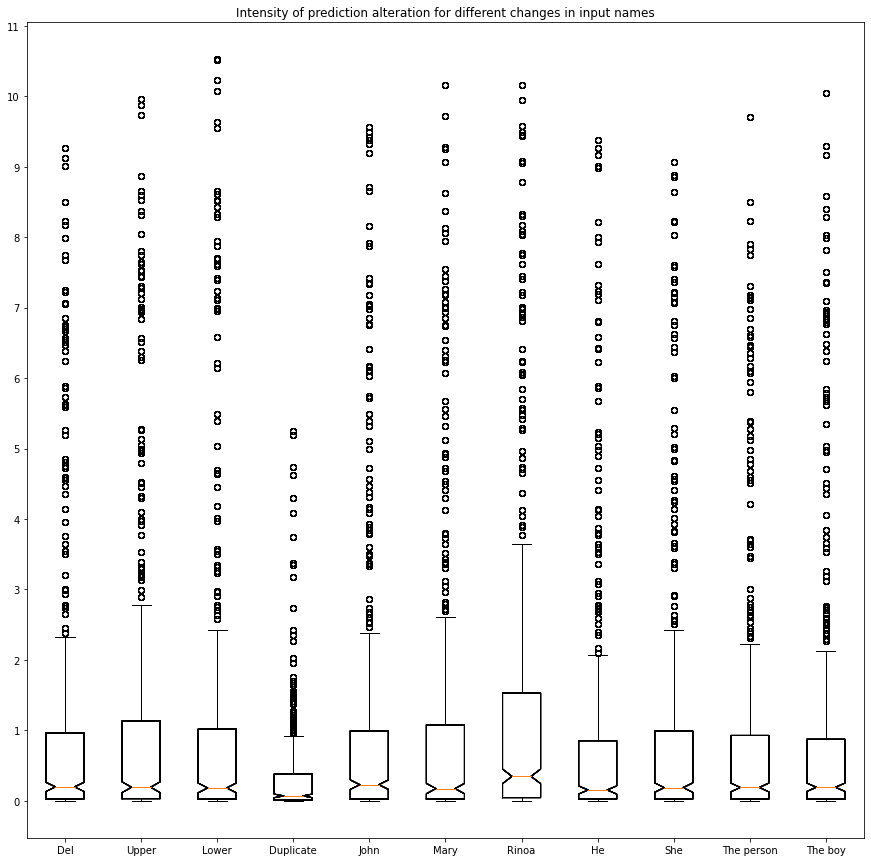

In [ ]:
from matplotlib import pyplot as plt

fig7, ax7 = plt.subplots( figsize=(15, 15))


ax7.set_title('Intensity of prediction alteration for different changes in input names')
for c in namespd_filtered.columns:

    ax7.boxplot([namespd_filtered['Del'], namespd_filtered['UPPER'], namespd_filtered['lower'],
    namespd_filtered['dupl'], namespd_filtered['john'], namespd_filtered['mary'], namespd_filtered['rinoa'],
    namespd_filtered['he'], namespd_filtered['she'], namespd_filtered['person'], namespd_filtered['boy']], notch=True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11],['Del','Upper','Lower','Duplicate','John','Mary','Rinoa','He','She','The person','The boy'])
plt.yticks(np.arange(0, 12, 1))

plt.show()

In [ ]:
namespd = pd.DataFrame(names_importance_list, 
                        columns = ['Name','Del','UPPER','lower','dupl','john','mary','rinoa','he','she','person','boy'])
print(namespd.head(10))
for c in namespd.columns:
    if c != 'Name':
        print(c, namespd[c].mean(), namespd[c].std())

        Name       Del     UPPER     lower      dupl      john      mary  \
0   Hercules  0.596714  0.110063  6.946629  0.840035  2.120444  1.666820   
1       Xena  1.122196  0.424272  0.383713  0.622384  2.078641  0.056183   
2    Segutav  7.067705  6.298752  0.850500  0.059448  8.655600  8.370857   
3  Gabrielle  0.674403  0.650441  0.981014  0.063390  0.554936  0.651711   
4   Kashyyik  0.933297  0.070598  0.212202  1.530677  0.567026  0.587326   
5       Ares  0.160610  0.392531  0.539757  0.156126  0.075551  0.048260   
6    Olympus  0.380299  0.087111  0.230506  0.257305  0.652213  0.544654   
7     Thrawn  0.198414  0.149970  0.460344  0.024037  0.247447  0.319648   
8  Gabrielle  0.013619  0.012840  0.042033  0.022701  0.012831  0.011175   
9       Xena  0.652241  0.008337  0.065313  0.003135  0.016324  0.005969   

      rinoa        he       she    person       boy  
0  4.122392  0.376160  0.198776  0.633927  0.473807  
1  2.187325  0.095121  0.249835  1.594170  0.126724  
2

In [ ]:
namesswpd = pd.DataFrame(names_switches_list, 
                        columns = ['Name','Del','UPPER','lower','dupl','john','mary','rinoa','he','she','person','boy'])
print(namesswpd.head(10))

for c in namesswpd.columns:
    if c != 'Name':
        print(c, 1 - (namesswpd[c].value_counts()[False] / len(namesswpd)))

        Name    Del  UPPER  lower   dupl   john   mary  rinoa     he    she  \
0   Hercules  False  False   True  False  False  False  False  False  False   
1       Xena  False  False  False  False  False  False  False  False  False   
2    Segutav   True   True  False  False   True   True  False   True   True   
3  Gabrielle  False  False  False  False  False  False  False  False  False   
4   Kashyyik  False  False  False  False  False  False  False  False  False   
5       Ares  False  False  False  False  False  False  False  False  False   
6    Olympus  False  False  False  False  False  False  False  False  False   
7     Thrawn  False  False  False  False  False  False  False  False  False   
8  Gabrielle  False  False  False  False  False  False  False  False  False   
9       Xena  False  False  False  False  False  False  False  False  False   

   person    boy  
0   False  False  
1   False  False  
2    True   True  
3   False  False  
4   False  False  
5   False  False

In [ ]:
subsamples = [0, 5, 10, 15, 20]
#res = []
names_importance_list = []
names_switches_list = []

atan = pd.read_csv("Attention analysis.csv", sep=';')
atan_from = atan.loc[atan["Direction"] == "From CLS"]

for count, textindex in enumerate(sample_indices):

    label = df['labels'][textindex]
    for s in subsamples:
        #cur_res = []

        correct = False
        segm = combine_segments_from_pd(textindex, s, 0) 
        #print(segm)
        prediction = pipeline_onesegment(segm, mode='labels')
        prediction = prediction[0]
        orig_logits = pipeline_onesegment(segm, mode='logits')
        if prediction == label:
            correct = True

        #cur_res += textindex, s, segm, label, correct, orig_logits

        
        text1, text2 = segm.split("$&*&*&$")
        inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

        with torch.no_grad():
            attention = model1(**inputs)[-1]
        
        top_features_sum, top_features_count, top_features_list = extract_attended_tokens_per_instance(attention, inputs)

        for index, feature in enumerate(top_features_sum['Feature'][:20]):

            if checkname(feature):
                print(feature)
                permutation, switches = permute_names(segm, orig_logits, feature)

                names_importance_list.append([feature]+permutation)
                names_switches_list.append([feature]+switches)
names_importance_list

In [ ]:
subsamples = [0, 5, 10, 15, 20]
all_features_list = []

atan = pd.read_csv("Attention analysis.csv", sep=';')
atan_from = atan.loc[atan["Direction"] == "From CLS"]

for count, textindex in enumerate(sample_indices):

    label = df['labels'][textindex]
    for s in subsamples:
 
        segm = combine_segments_from_pd(textindex, s, 0) 
        
        text1, text2 = segm.split("$&*&*&$")
        inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

        with torch.no_grad():
            attention = model1(**inputs)[-1]
        
        top_features_sum, top_features_count, top_features_list = extract_attended_tokens_per_instance(attention, inputs)

        all_features_list += top_features_list

        

In [ ]:
subsamples = [0, 5, 10, 15, 20]
res = []
all_features_list = []

atan = pd.read_csv("Attention analysis.csv", sep=';')
atan_from = atan.loc[atan["Direction"] == "From CLS"]

for count, textindex in enumerate(sample_indices):

    label = df['labels'][textindex]
    for s in subsamples:
        cur_res = []

        correct = False
        segm = combine_segments_from_pd(textindex, s, 0) 
        #print(segm)
        prediction = pipeline_onesegment(segm, mode='labels')
        prediction = prediction[0]
        orig_logits = pipeline_onesegment(segm, mode='logits')
        if prediction == label:
            correct = True

        cur_res += textindex, s, segm, label, correct, orig_logits

        
        text1, text2 = segm.split("$&*&*&$")
        inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')

        with torch.no_grad():
            attention = model1(**inputs)[-1]
        
        top_features_sum, top_features_count, top_features_list = extract_attended_tokens_per_instance(attention, inputs)

        #print(top_features_sum.head(10))

        top_wordlist = []
        top_weights = []
        switches = []
        mean_change = []
        for index, feature in enumerate(top_features_sum['Feature'][:20]):

            #if feature not in "$&*":
                
            permutation = permute(segm, orig_logits, feature)

            top_wordlist.append({feature: top_features_sum.iloc[[index]]['Weight']})
            top_weights.append({feature: permutation})
            switches.append(permutation[2])
            mean_change.append(np.mean([np.abs(permutation[0]), np.abs(permutation[1])]))
            #else:
            #    continue
        
        percent_switches = switches.count(True) / len(switches)

        cur_res += top_features_list, top_wordlist, top_weights, percent_switches, mean_change

        all_features_list += top_features_list

        res.append(cur_res)

1ex [00:00, 999.36ex/s]
1ex [00:00, 999.36ex/s]
1ex [00:00, 499.62ex/s]
1ex [00:00, 499.98ex/s]
1ex [00:00, 1000.55ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, ?ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.36ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 1000.07ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 499.92ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 998.88ex/s]
1ex [00:00, 1000.07ex/s]
1ex [00:00, 1000.31ex/s]
1ex [00:00, ?ex/s]
1ex [00:00, 999.36ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 1000.07ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 1000.55ex/s]
1ex [00:00, 999.12ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 1000.31ex/s]
1ex [00:00, 1000.31ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83

In [ ]:
all_features_count1 = Counter(all_features_list1)
all_features_count1.most_common()

[('.', 1666),
 ('"', 360),
 ('said', 131),
 ('was', 70),
 (',', 66),
 ('had', 52),
 ('and', 39),
 ('asked', 38),
 ('replied', 32),
 ('!', 32),
 ('then', 19),
 ('d', 19),
 (';', 18),
 (':', 15),
 ('would', 13),
 (')', 13),
 ('Sumireko', 13),
 ('stated', 12),
 ('thought', 12),
 ('were', 12),
 ('moved', 11),
 ('walked', 10),
 ('(', 10),
 ('as', 10),
 ('yelled', 10),
 ('felt', 9),
 ('sat', 9),
 ('countered', 9),
 ('responded', 9),
 ("'", 8),
 ('_', 8),
 ('Sakai', 7),
 ('looked', 7),
 ('is', 7),
 ('my', 7),
 ('could', 7),
 ('Beetlejuice', 7),
 ('Mitani', 7),
 ('like', 6),
 ('-', 6),
 ('turned', 6),
 ('towards', 6),
 ('Diego', 6),
 ('Frisk', 6),
 ('Tokaku', 5),
 ('Chapter', 5),
 ('made', 5),
 ('explained', 5),
 ('smiled', 5),
 ('nodded', 5),
 ('began', 5),
 ('Thanks', 5),
 ('her', 5),
 ('against', 5),
 ('wasn', 5),
 ('I', 5),
 ('stopped', 5),
 ('?', 5),
 ('Tidus', 5),
 ('Tattoon', 5),
 ('~', 5),
 ('Zexion', 5),
 ('tone', 4),
 ('saw', 4),
 ('stalls', 4),
 ('to', 4),
 ('glanced', 4),
 ('Stoppi

In [ ]:
all_features_count = Counter(all_features_list)
all_features_count.most_common()

[('.', 24466),
 ('"', 4829),
 (',', 3821),
 ('I', 1378),
 ('and', 1105),
 ('-', 873),
 ('said', 865),
 ("'", 601),
 ('the', 579),
 ('was', 557),
 ('Tokaku', 517),
 ('Zexion', 516),
 ('Midorima', 504),
 ('Beetlejuice', 500),
 ('Maeve', 498),
 ('her', 473),
 ('He', 444),
 ('that', 444),
 ('Mitani', 420),
 ('Sumireko', 411),
 ('then', 395),
 ('Frisk', 393),
 ('as', 390),
 ('Gabrielle', 388),
 ('had', 378),
 ('Takao', 378),
 ('she', 376),
 ('asked', 372),
 ('Carrie', 371),
 ('Sinbad', 367),
 ('he', 359),
 ('Xena', 354),
 ('Genrou', 352),
 ('The', 321),
 ('Nepgear', 321),
 ('Mahiru', 313),
 ('Roman', 290),
 ('Ares', 288),
 ('Undyne', 287),
 ('Kurt', 286),
 ('Thrash', 280),
 ('Haru', 279),
 ('She', 265),
 ('Demyx', 265),
 ('Axl', 264),
 ('his', 263),
 ('Kurei', 254),
 (';', 244),
 ('Throttle', 244),
 ('!', 237),
 ('Sakai', 235),
 ('Tidus', 235),
 ('Hikaru', 234),
 ('me', 232),
 ('is', 224),
 ('Haruhi', 224),
 ('Panel', 222),
 ('replied', 214),
 ('of', 205),
 ('Mettaton', 205),
 ('?', 199),
 

In [ ]:
resattpd = pd.DataFrame(res, columns = ['index', 'segment', 'text', 'label', 'correctness', 'logits', 'topwords_weight', 'topwords_change', "mean_switch", 'mean_change'])

In [ ]:
resattpd.to_csv('res_att_100.csv', index=False)

In [ ]:
permutation = permute(segm, orig_logits, feature)
permutation

1ex [00:00, 1000.31ex/s]


[-0.0032367706, 0.0026726723, False]

In [ ]:
change = np.mean([np.abs(permutation[0]), np.abs(permutation[1])])
change

0.0029547215

In [ ]:
res[0][9]



[9.032924,
 0.59671354,
 1.122196,
 6.2220407,
 1.3869469,
 7.067705,
 0.67440295,
 0.93329716,
 0.16060996,
 0.88407516,
 0.38029933,
 0.40639496,
 0.19841433,
 2.1631699,
 0.800467,
 0.75075364,
 0.09042215,
 0.46844602,
 0.77307725,
 0.94281316]

In [ ]:
p = permute(text, orig_logits, "Sara")
print(p)

1ex [00:00, 1000.31ex/s]


[{'Sara': [0.09421468, -0.10359132, False]}]


In [ ]:
for feature in acpd.index[:10]:
    print(feature)

.
Mitani
"
said
,
otchan
Pez
Jimmy
yelled
man


In [ ]:
acpd[:10]

,0
.,230
Mitani,169
"""",78
said,67
",",53
otchan,44
Pez,25
Jimmy,22
yelled,18
man,15


In [ ]:
p = permute_names(text, orig_logits, "Sara")
print(p)

1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 1000.07ex/s]
1ex [00:00, 999.83ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 1000.07ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.60ex/s]
1ex [00:00, 999.60ex/s]


[[0.098903, False, ''], [1.1827569, False, 'SARA'], [1.557944, False, 'sara'], [1.675195, False, 'Sara Sara'], [0.18852329, False, 'John'], [1.1559482, False, 'Mary'], [3.1328135, False, 'Rinoa'], [0.8424066, False, 'he'], [0.24715126, False, 'she'], [1.7444751, False, 'the person'], [0.44825488, False, 'the Boy']]


In [ ]:
p[1]

[[0.09421468, 0.10359132],
 [1.0958736, 1.2696403],
 [1.3820512, 1.733837],
 [1.9400724, 1.4103174],
 [0.16820192, 0.20884466],
 [1.3494493, 0.9624471],
 [2.5202987, 3.7453284],
 [0.79020214, 0.894611],
 [0.22165179, 0.27265072],
 [1.5245259, 1.9644245],
 [0.42430854, 0.47220123]]

In [ ]:
p[1]

[[0.09421468, -0.10359132],
 [1.0958736, -1.2696403],
 [1.3820512, -1.733837],
 [-1.9400724, 1.4103174],
 [0.16820192, -0.20884466],
 [-1.3494493, 0.9624471],
 [2.5202987, -3.7453284],
 [0.79020214, -0.894611],
 [0.22165179, -0.27265072],
 [1.5245259, -1.9644245],
 [0.42430854, -0.47220123]]

In [ ]:
for i in inputs:
    print(i)

input_ids
token_type_ids
attention_mask


In [ ]:
a = attention_per_layer(attention, 0, threshold = 0.015, mode="counter")
a

[('[CLS]', 8),
 ('[SEP]', 7),
 (',', 5),
 ('.', 3),
 ('two', 2),
 ('to', 2),
 ('Hmm', 2),
 ('of', 2),
 ('sells', 1),
 ('Lisa', 1),
 ('rush', 1),
 ('##dies', 1),
 ('We', 1),
 ('desperate', 1),
 ('sugar', 1),
 ('##til', 1),
 ('and', 1),
 ('but', 1),
 ('or', 1),
 ('the', 1),
 ('a', 1),
 ('Just', 1),
 ('Mi', 1),
 ('No', 1),
 ('Forget', 1),
 ('ins', 1),
 ('thoughtfully', 1),
 ('##ling', 1),
 ('##ing', 1),
 ('##tani', 1)]

In [ ]:
attentions = []
for text in respd['text']:
    text1, text2 = text.split("$&*&*&$")
    inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')
    with torch.no_grad():
        attention = model1(**inputs)[-1]
    cls_attention = attention_general(attention, threshold = 0.01, mode='counter')
    attentions += [cls_attention]

attentions_pd = pd.DataFrame(attentions)

In [ ]:
set_attentions = []
for text in respd['text']:
    text1, text2 = text.split("$&*&*&$")
    inputs = tokenizer1(text1, text2, truncation=True, padding='max_length', max_length=255, return_tensors='pt')
    with torch.no_grad():
        attention = model1(**inputs)[-1]
    cls_attention = attention_general(attention)
    set_attentions += [cls_attention]

set_attentions_pd = pd.DataFrame(set_attentions)

In [ ]:
allattset = []
for attset in set_attentions_pd[11]:
    allattset += list(attset)

count = Counter(allattset)
count = count.most_common()
count

#set separately for each layer, but for all heads, for all instances in our sample


[('.', 100),
 ('[SEP]', 100),
 (',', 96),
 ('"', 95),
 ('and', 71),
 ('[CLS]', 53),
 ('the', 46),
 ('He', 44),
 ('said', 39),
 ('her', 37),
 ('he', 36),
 ('his', 36),
 ('The', 36),
 ('as', 35),
 ('-', 34),
 ('that', 33),
 ('was', 29),
 ('she', 29),
 ('I', 28),
 ('asked', 28),
 ('had', 25),
 ('with', 23),
 ('but', 21),
 ('She', 20),
 ('then', 20),
 ('before', 20),
 ('of', 19),
 ('him', 18),
 ('s', 17),
 ('to', 17),
 ('a', 16),
 (';', 16),
 ('not', 14),
 ('replied', 13),
 ('when', 13),
 ('?', 12),
 ('would', 12),
 ('is', 12),
 ('##u', 12),
 ('in', 11),
 ('so', 11),
 ('##ka', 11),
 ('But', 10),
 ('on', 9),
 ('were', 9),
 ('them', 9),
 ('!', 9),
 ('didn', 9),
 ('##ori', 9),
 ('t', 9),
 ('##ly', 8),
 ('you', 8),
 ('And', 8),
 ('all', 8),
 ('they', 8),
 ('##ru', 8),
 ('##s', 8),
 ('it', 8),
 ('Mid', 8),
 ('for', 7),
 ('have', 7),
 ('thought', 7),
 ('which', 7),
 ('So', 7),
 ('girl', 7),
 ("'", 7),
 ('from', 7),
 (':', 7),
 ('me', 7),
 ('my', 7),
 ('over', 7),
 ('d', 7),
 ('stated', 6),
 ('##

In [ ]:
attended_by_cls = []

for layernum, layer in enumerate(attention):
    #print(layernum)
    for headnum, head in enumerate(layer[0]):
        #print(headnum)
        cls = head[0]
        sorted, indices = torch.sort(cls, descending=True)
        for word in indices[:10]:
            attended_by_cls.append(tokenizer1.decode(inputs['input_ids'][0][word]))

print(len(attended_by_cls))
from collections import Counter

count = Counter(attended_by_cls)
count = count.most_common()
count
        

1440


[('.', 248),
 ('[SEP]', 216),
 ('##ena', 122),
 ('"', 105),
 ('Hercules', 72),
 ('[CLS]', 59),
 ('Gabrielle', 52),
 ('replied', 34),
 ('X', 30),
 (',', 26),
 ('##mpus', 18),
 ('asked', 17),
 ('##v', 16),
 ('Ares', 16),
 ('Admiral', 15),
 ('kindly', 14),
 ('The', 13),
 ('##ta', 13),
 ('stated', 13),
 ('Sir', 12),
 ('##yi', 12),
 ('##gu', 12),
 ('the', 11),
 ('bridge', 10),
 ('ale', 9),
 ('demanded', 9),
 ('ordered', 9),
 ('##wn', 9),
 ('##sh', 8),
 ('and', 8),
 ('dreaming', 8),
 ('woke', 8),
 ('fleet', 8),
 ('sob', 8),
 ('##hh', 7),
 ('a', 7),
 ('Ghost', 7),
 ('Squadron', 7),
 ('put', 7),
 ('Ah', 6),
 ('fetch', 6),
 ('##sir', 6),
 ('in', 6),
 ('commander', 6),
 ('Mount', 6),
 ('Se', 5),
 ('reports', 5),
 ('I', 5),
 ('heard', 5),
 ('we', 5),
 ('Set', 4),
 ('ve', 4),
 ('of', 4),
 ('##bed', 4),
 ('sole', 4),
 ('this', 4),
 ('when', 4),
 ('thank', 3),
 ('##ed', 3),
 ('so', 3),
 ('jumped', 3),
 ('Phoenix', 3),
 ('crew', 3),
 ('by', 3),
 ('location', 3),
 ('accent', 3),
 ('##p', 3),
 ('he', 3

In [ ]:
df.iloc[[4433]]

4433    0
Name: labels, dtype: int64